In [9]:
from google.colab import drive
drive.mount('/content/drive')
path = '.../data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import pandas as pd
from fastai.vision.all import *
from sklearn.model_selection import train_test_split
import os
from glob import glob
from sklearn import metrics
import numpy as np
import random
from collections import defaultdict

In [11]:
def create_sex_biased_test_set(df, non_df, bias):
    """
    Adjusts the gender composition of two datasets to introduce a specified bias
    in the proportion of female ('F') individuals.

    Parameters:
        df (DataFrame): The first dataset containing a "Gender" column.
        non_df (DataFrame): The second dataset containing a "Gender" column.
        bias (float): The desired proportion of female individuals in df.

    Returns:
        DataFrame: A concatenated DataFrame with the modified df and non_df
                   after adjusting for the gender bias.
    """

    # Calculate the current proportion of female ('F') individuals in each dataset
    prop1 = sum(df['Gender'] == 'F') / len(df)
    prop2 = sum(non_df['Gender'] == 'F') / len(non_df)

    # Adjust the df dataset based on the desired bias level
    if bias <= prop1:
        # If the target bias is lower than or equal to the current proportion,
        # oversample female ('F') individuals to reach the desired proportion
        biased_df = pd.concat([
            df,
            df[df['Gender'] == 'F'].sample(
                int((sum(df['Gender'] == 'F') - len(df) * bias) / (1 - bias)),
                random_state=2022
            )
        ]).drop_duplicates(subset=['Path'], keep=False)
    else:
        # If the target bias is higher than the current proportion,
        # oversample male ('M') individuals to reduce the proportion of females
        biased_df = pd.concat([
            df,
            df[df['Gender'] == 'M'].sample(
                int((sum(df['Gender'] == 'M') - len(df) * (1 - bias)) / bias),
                random_state=2022
            )
        ]).drop_duplicates(subset=['Path'], keep=False)

    # Calculate the complementary bias for the other dataset
    bias2 = 1 - bias

    # Adjust the non_df dataset similarly but based on bias2
    if bias2 <= prop2:
        # If the target bias is lower than or equal to the current proportion,
        # oversample female ('F') individuals in non_df
        biased_non_df = pd.concat([
            non_df,
            non_df[non_df['Gender'] == 'F'].sample(
                int((sum(non_df['Gender'] == 'F') - len(non_df) * bias2) / (1 - bias2)),
                random_state=2022
            )
        ]).drop_duplicates(subset=['Path'], keep=False)
    else:
        # If the target bias is higher than the current proportion,
        # oversample male ('M') individuals in non_df
        biased_non_df = pd.concat([
            non_df,
            non_df[non_df['Gender'] == 'M'].sample(
                int((sum(non_df['Gender'] == 'M') - len(non_df) * (1 - bias2)) / bias2),
                random_state=2022
            )
        ]).drop_duplicates(subset=['Path'], keep=False)

    # Return the final biased dataset by combining both modified datasets
    return pd.concat([biased_df, biased_non_df])


def binarize_by_age(df, age):
    
    #Splits a dataset into two subsets based on a given age category.

    # Filter dataset to create a subset where "Patient Age Category" matches the given age
    age_df = df[df['Patient Age Category'] == age]

    # Filter dataset to create a subset where "Patient Age Category" does NOT match the given age
    non_age_df = df[df['Patient Age Category'] != age]

    # Return both subsets
    return age_df, non_age_df


CheXpert Trained;
MIMIC Tested

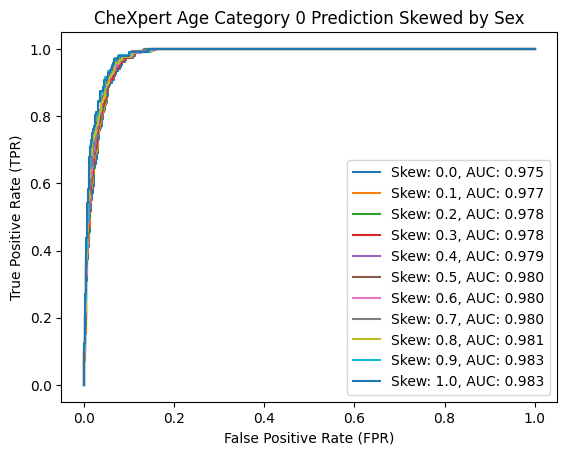

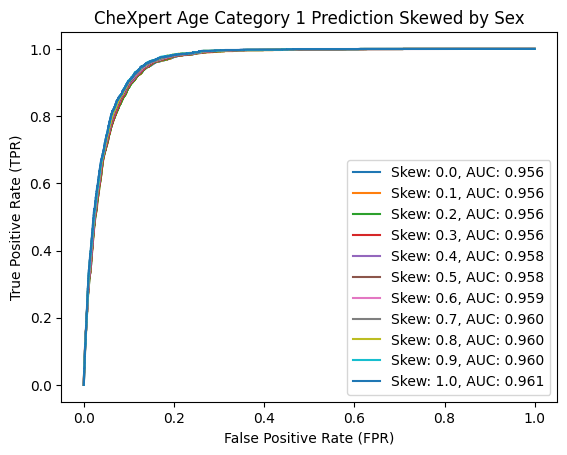

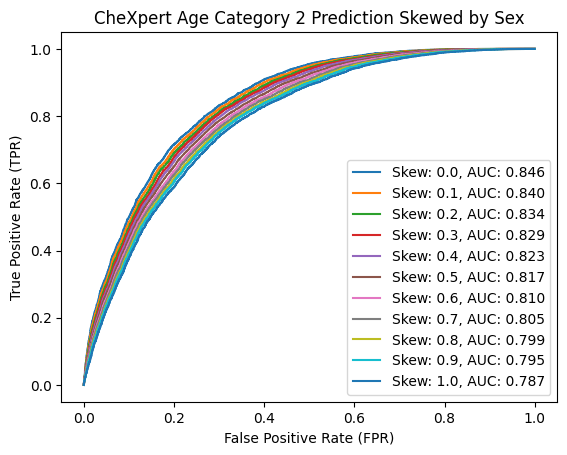

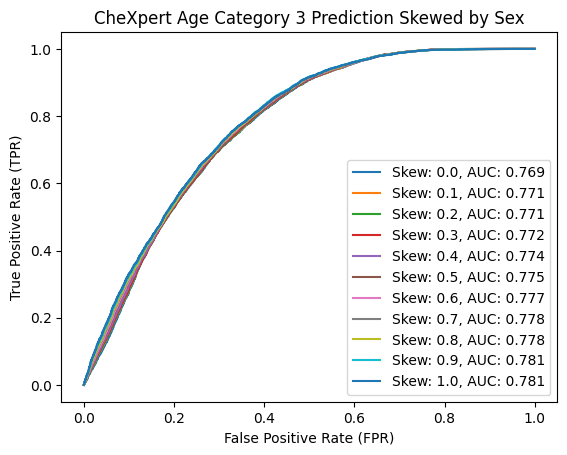

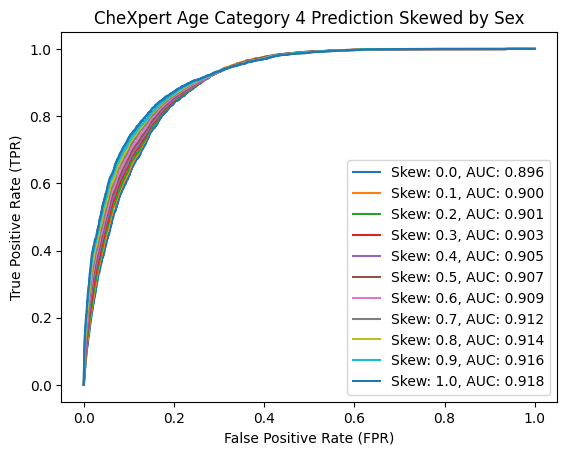

In [12]:
ages = [0, 1, 2, 3, 4]
for age in ages:
  df = pd.read_csv(path + '/chexpert_age_mimic_test.csv')
  df = df[~df['Gender'].isna()]
  df['Age_Probability'] = df['Age_Probability'].str.rstrip(']')
  df['Age_Probability'] = df['Age_Probability'].str.lstrip('[')
  df['Age_Probability'] = df['Age_Probability'].apply(np.fromstring, sep=',', dtype = float)
  age_df, nonage_df = binarize_by_age(df, age)
  #For each bias/skew, created the appropriate skewed dataset and calculate AUCROC
  for bias in np.arange(0, 1.1, 0.1):
      biased_test_df = create_sex_biased_test_set(age_df, nonage_df, bias)
      fpr, tpr, _ = metrics.roc_curve(y_true = biased_test_df['Patient Age Category'],y_score = [prob[age] for prob in biased_test_df['Age_Probability']], pos_label = age)
      auc = metrics.auc(fpr, tpr)
      plt.plot(fpr, tpr, label=f'Skew: {bias:.1f}, AUC: {auc:.3f}')
  # Add labels, title, and legend
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc='lower right')
  plt.title('CheXpert Age Category ' + str(age) + ' Prediction Skewed by Sex')
  # Show the plot
  plt.show()

CheXpert Trained; CheXpert Tested

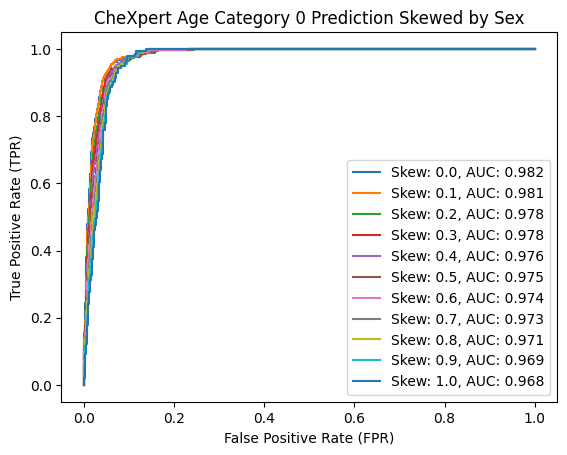

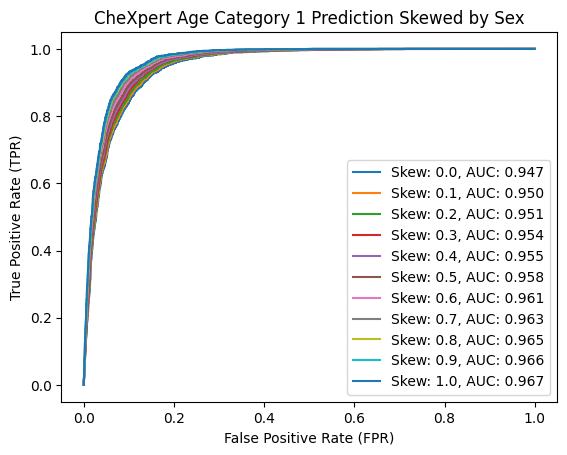

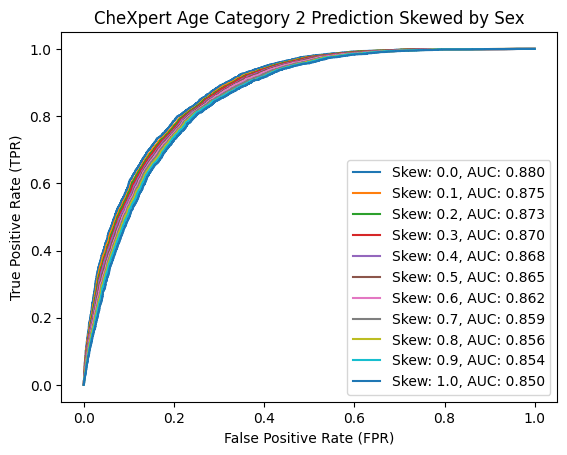

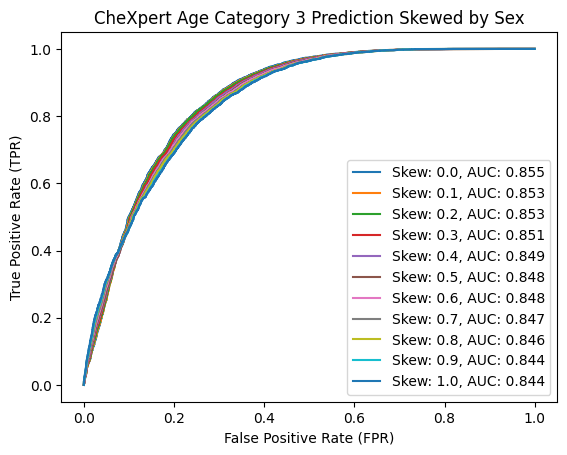

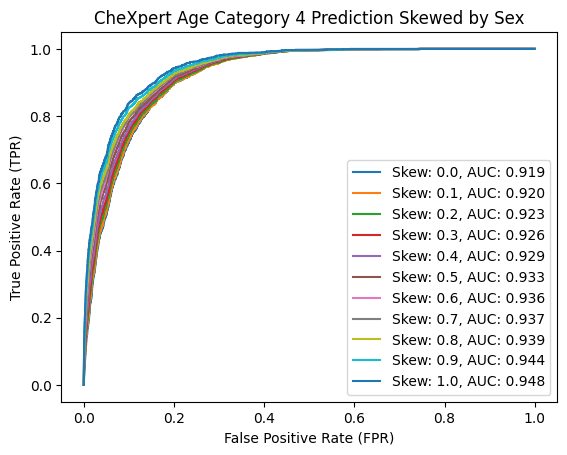

In [13]:
ages = [0, 1, 2, 3, 4]
for age in ages:
  df = pd.read_csv(path + '/chexpert_age_chexpert_test.csv')
  df = df[~df['Gender'].isna()]
  df['Age_Probability'] = df['Age_Probability'].str.rstrip(']')
  df['Age_Probability'] = df['Age_Probability'].str.lstrip('[')
  df['Age_Probability'] = df['Age_Probability'].apply(np.fromstring, sep=',', dtype = float)
  age_df, nonage_df = binarize_by_age(df, age)
  for bias in np.arange(0, 1.1, 0.1):
      biased_test_df = create_sex_biased_test_set(age_df, nonage_df, bias)
      fpr, tpr, _ = metrics.roc_curve(y_true = biased_test_df['Patient Age Category'],y_score = [prob[age] for prob in biased_test_df['Age_Probability']], pos_label = age)
      auc = metrics.auc(fpr, tpr)
      plt.plot(fpr, tpr, label=f'Skew: {bias:.1f}, AUC: {auc:.3f}')
  # Add labels, title, and legend
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc='lower right')
  plt.title('CheXpert Age Category ' + str(age) + ' Prediction Skewed by Sex')
  # Show the plot
  plt.show()

MIMIC Trained;
MIMIC Tested

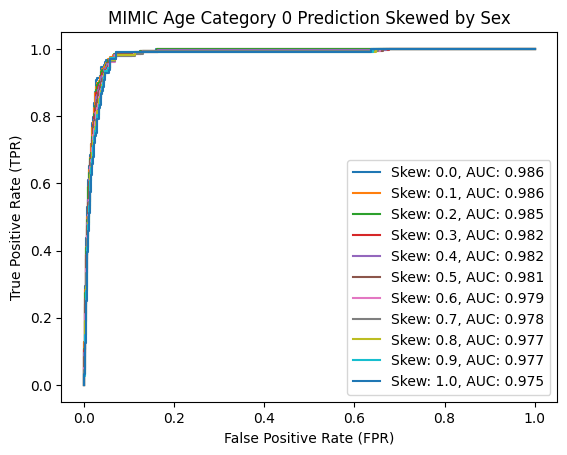

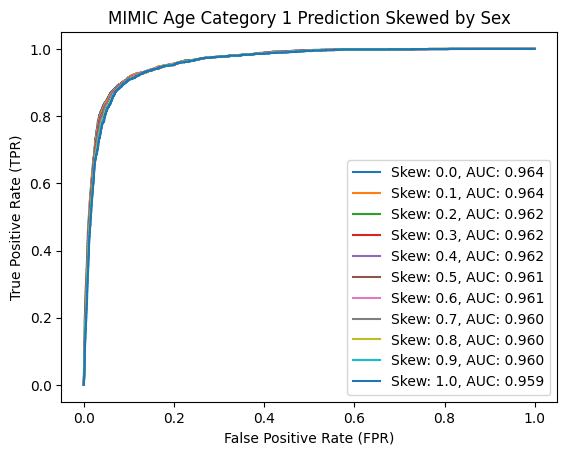

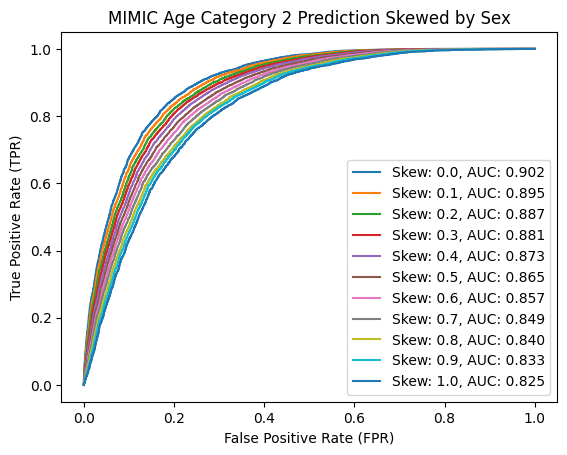

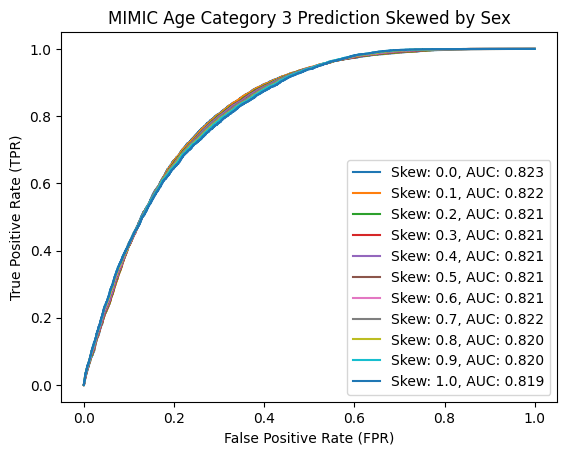

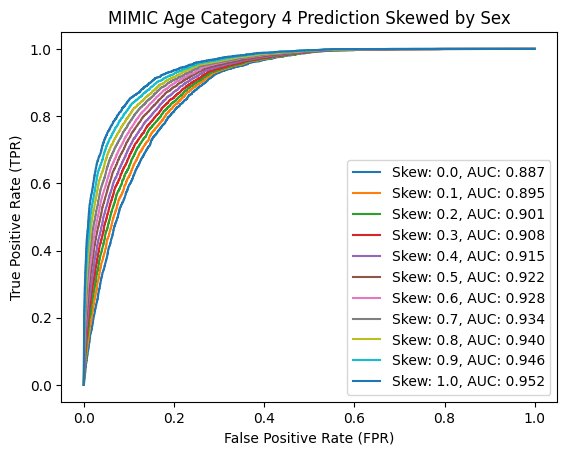

In [14]:
ages = [0, 1, 2, 3, 4]
for age in ages:
  df = pd.read_csv(path + '/mimic_age_mimic_test.csv')
  df = df[~df['Gender'].isna()]
  df['Age_Probability'] = df['Age_Probability'].str.rstrip(']')
  df['Age_Probability'] = df['Age_Probability'].str.lstrip('[')
  df['Age_Probability'] = df['Age_Probability'].apply(np.fromstring, sep=',', dtype = float)
  age_df, nonage_df = binarize_by_age(df, age)
  for bias in np.arange(0, 1.1, 0.1):
      biased_test_df = create_sex_biased_test_set(age_df, nonage_df, bias)
      fpr, tpr, _ = metrics.roc_curve(y_true = biased_test_df['Patient Age Category'],y_score = [prob[age] for prob in biased_test_df['Age_Probability']], pos_label = age)
      auc = metrics.auc(fpr, tpr)
      plt.plot(fpr, tpr, label=f'Skew: {bias:.1f}, AUC: {auc:.3f}')
  # Add labels, title, and legend
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc='lower right')
  plt.title('MIMIC Age Category ' + str(age) + ' Prediction Skewed by Sex')
  # Show the plot
  plt.show()

MIMIC Trained;
CheXpert Tested

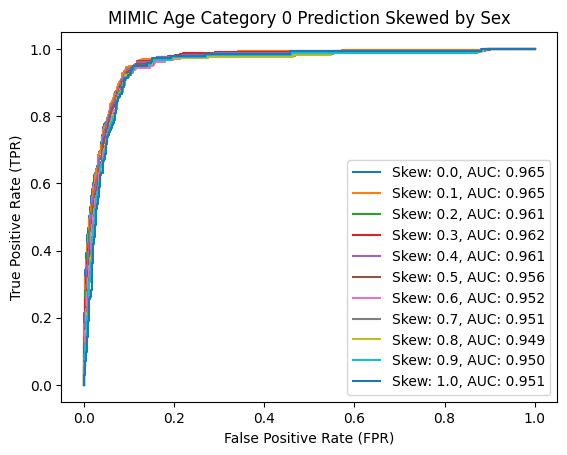

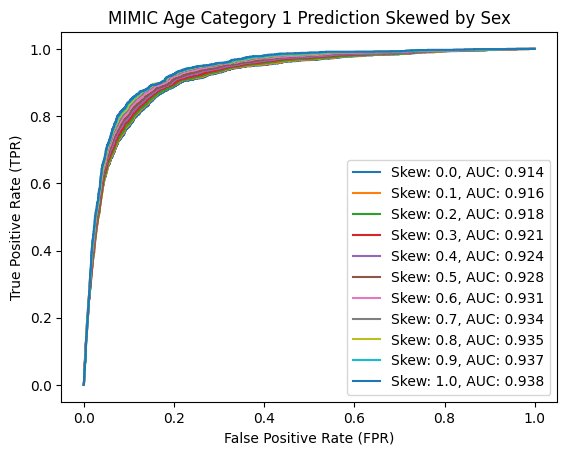

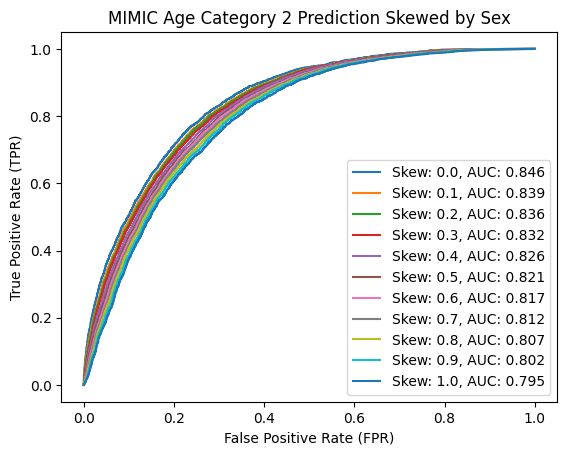

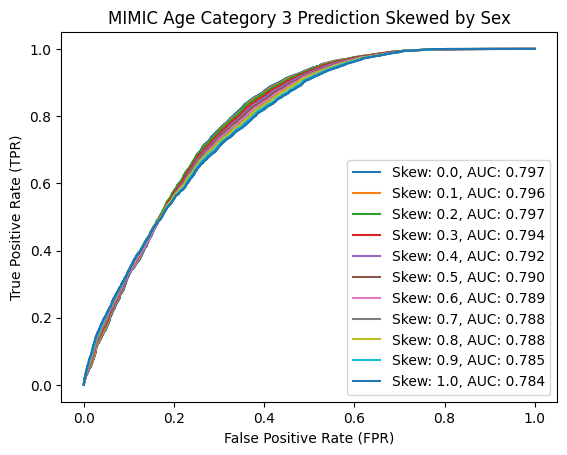

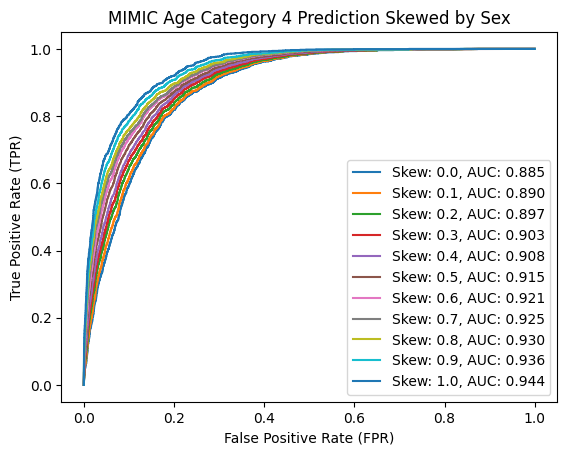

In [15]:
ages = [0, 1, 2, 3, 4]
for age in ages:
  df = pd.read_csv(path + '/mimic_age_chexpert_test.csv')
  df = df[~df['Gender'].isna()]
  df['Age_Probability'] = df['Age_Probability'].str.rstrip(']')
  df['Age_Probability'] = df['Age_Probability'].str.lstrip('[')
  df['Age_Probability'] = df['Age_Probability'].apply(np.fromstring, sep=',', dtype = float)
  age_df, nonage_df = binarize_by_age(df, age)
  for bias in np.arange(0, 1.1, 0.1):
      biased_test_df = create_sex_biased_test_set(age_df, nonage_df, bias)
      fpr, tpr, _ = metrics.roc_curve(y_true = biased_test_df['Patient Age Category'],y_score = [prob[age] for prob in biased_test_df['Age_Probability']], pos_label = age)
      auc = metrics.auc(fpr, tpr)
      plt.plot(fpr, tpr, label=f'Skew: {bias:.1f}, AUC: {auc:.3f}')
  # Add labels, title, and legend
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc='lower right')
  plt.title('MIMIC Age Category ' + str(age) + ' Prediction Skewed by Sex')
  # Show the plot
  plt.show()